## Nx Graph

In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import networkx as nx
import numpy as np
import time
from scipy.sparse import *
from scipy import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from numpy import linalg
from matplotlib.pyplot import figure
import random
import scipy.special
import itertools
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm
from collections import Counter

In [2]:
def convert(string):
    li = list(string.split(" "))
    return li

In [3]:
def kmeans(k, t, A):

    kmeans = KMeans(n_clusters=k, init = 'k-means++', algorithm='auto', max_iter=t).fit(A)
    
    # id_supernode : list of id_nodes in it
    partition = {i: np.where(kmeans.labels_ == i)[0] for i in range(k)}
    
    #id_node : id_supernode it belongs to
    supernode = {}
    for k,v in partition.items():
        for el in v:
            supernode[el] = k
  
    return partition, supernode

In [4]:
def lifted_density_matrix(S, n, partition, supernode):
    
    t0 = time.time()
    S_lifted = lil_matrix((n,n), dtype=float) 
    S_grass = lil_matrix((n,n), dtype=float) 
    for i in tqdm(range(n)):
        for j in range(n):
            s_i = supernode[i]
            s_j = supernode[j]
            
            S_lifted[i,j] = S[s_i, s_j]
            if s_i != s_j :
                S_grass[i,j] = S_lifted[i,j] 
            elif i != j:
                S_grass[i,j] = S_lifted[i,j] * len(partition[s_j])/(len(partition[s_j])-1)   
            else:
                S_grass[i,j] = 0
    t1 = time.time()
    print('Running time A_S_lifted + Grass: %f' %(t1-t0))
    return S_lifted,S_grass 

In [5]:
def density_matrix(k, partition, A, n, supernode):
    
    t0 = time.time()
    
    S = dok_matrix((k,k))        #density matrix of the expected weights
    S_prob = dok_matrix((k,k))
    
    for el in nx.generate_edgelist(G):
        el = convert(el)
        el[0] = int(el[0])
        el[1] = int(el[1])
        S[supernode[el[0]], supernode[el[1]]] +=  A[el[0],el[1]]
        S_prob[supernode[el[0]], supernode[el[1]]] +=  1
         
    for i in range(k): 
        for j in range(k): 
            S[i,j] = S[i,j]/(len(partition[i])*len(partition[j]))
            S_prob[i,j] = S_prob[i,j]/(len(partition[i])*len(partition[j]))
                    
    t1 = time.time()
    print('Running time S (kxk): %f' %(t1-t0))
    
    
   # S_probs, S_probs_G = lifted_density_matrix(S_prob,n,partition,supernode)
    #S, S_G = lifted_density_matrix(S,n,partition,supernode)
    return S_prob, S
    #return  S_probs, S_probs_G,  S, S_G

In [6]:
def summ(G, n, k, t):
    
    A = nx.adjacency_matrix(G)
    
    #partition given by the clustering
    t0=time.time()
    partition, supernode = kmeans(k, t, A)
    t1 = time.time()
    print('K-means: %f' %(t1-t0)) 
   
    
    S_probs,S = density_matrix(k, partition, A, n, supernode)
 
    return  S_probs, S, partition, supernode

In [7]:
random.seed(123)

In [13]:
random.seed(123)
n = 1000
m = 10000
G = nx.gnm_random_graph(n,m, directed=True)
for (u,v,w) in G.edges(data=True):
    weight = random.randint(1,250000)
    w['weight'] = weight

In [9]:
t0 = time.time()
k = 250
S_probs, S, partition, supernode = summ(G,n,k,20)
t1 = time.time()

print('Total running time: %f' %(t1-t0)) 

K-means: 6.321812
Running time S (kxk): 4.702435
Total running time: 11.141651


ValueError: Received invalid argument(s): edge_labels

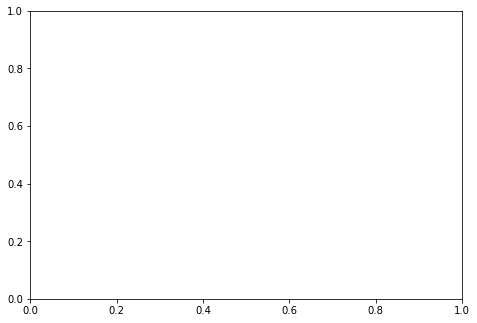

In [42]:
G = nx.MultiDiGraph()
G.add_edge(1,2,weight=8)
G.add_edge(1,2,weight=3)
G.add_edge(2,3,weight=4)
G.add_edge(2,3,weight=6)

pos = nx.random_layout(G)

edges = G.edges()

weight = []

for (u,v,attrib_dict) in list(G.edges.data()):
    weight.append(attrib_dict['weight'])


nx.draw(G, pos,  edge_labels=weight )
plt.show()

## Thresholding

In [11]:
A = nx.adjacency_matrix(G)

In [78]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A_th = lil_matrix((1000,1000), dtype=float) 
#A_th[A>0] = 1


th = 0.01
# thresholding for number of SuperEdges
S_probs_th = lil_matrix((1000,1000), dtype=float) 
S_probs_th[S_probs<th] = 0
S_probs_th[S_probs>=th] = 1

# thresholding for l2 error
S_th = S
S_th[S_probs<th] = 0

In [79]:
#l2 error
print('Error l2: with A_S', round(linalg.norm(A.A-S_th.A)))

Error l2: with A_S 13363919


In [80]:
#Number of SuperEdges
print('Edges in the Grass lifted summary matrix',np.count_nonzero(S_probs_th.A))

Edges in the Grass lifted summary matrix 1209


## Weights comparison

In [37]:
#summary graph
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [38]:
def get_edge_attributes(G, name):
    edges = G.edges(data=True)
    return [ x[-1]['weight'] for x in edges]

In [39]:
#w_G = get_edge_attributes(G, 'weight')
w_S = get_edge_attributes(s, 'weight')

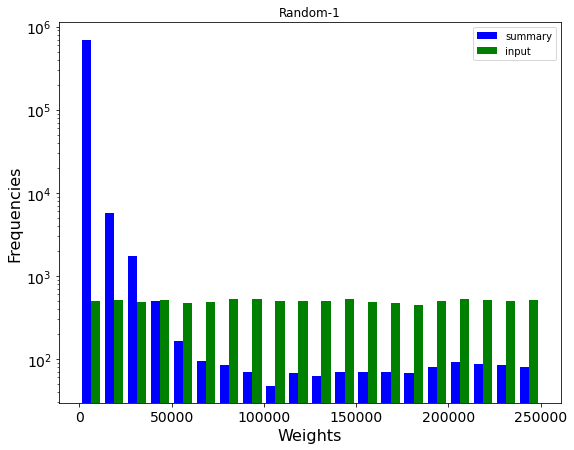

In [40]:
colors = ['b','g']
#plots the histogram
fig, ax1 = plt.subplots(figsize=(9,7))
ax1.hist([w_S,w_G],color=colors, bins=20, log=True, label = ['summary','input'])
plt.title("Random-1")
plt.xlabel("Weights", fontsize=16)  
plt.ylabel("Frequencies", fontsize=16)
plt.legend(loc="upper right")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

## Degree queries

In [10]:
A = nx.adjacency_matrix(G)

In [60]:
#save the errors for any node

s_out_tot = []
s_in_tot = []

In [256]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A[A>0] = 1
# grass -> negative values became 0, positive values 1 

#Th = 0.02, 0.05, 0.1, 0.25, 0.5, 0.75
probs_G = lil_matrix((1000,1000), dtype=float) 
probs_G[S_probs_G<0.75]= 0
probs_G[S_probs_G>=0.75] = 1

In [79]:
#discretize for weighted degree
S_G_dq = S_G 
S_G_dq[S_probs_G<0.75]= 0

In [80]:
#out degree queries percentage
s_out = []

for i in tqdm(range(1000)):
    sumA = np.sum(A[i,:])
    #sumS = np.sum(probs_G[i,:])
    sumS = np.sum(S_G_dq[i,:])
    s_out.append((abs(sumA - sumS))/sumA )
    
s_out_tot.append(round(np.mean(s_out),2))
print("Average error in adjacency queries", round(np.mean(s_out),2))

100%|██████████| 1000/1000 [00:00<00:00, 1460.88it/s]

Average error in adjacency queries 0.89


In [81]:
#in degree queries percentage
s_in = []

for i in tqdm(range(1000)):
    sumA = np.sum(A[:,i])
    #sumS = np.sum(probs_G[:,i])
    sumS = np.sum(S_G_dq[:,i])
    if sumA !=0:
        s_in.append((abs(sumA - sumS))/sumA )


s_in_tot.append(round(np.mean(s_in),2))
print("Average error in adjacency queries", round(np.mean(s_in),2))

100%|██████████| 1000/1000 [00:02<00:00, 438.12it/s]

Average error in adjacency queries 0.85


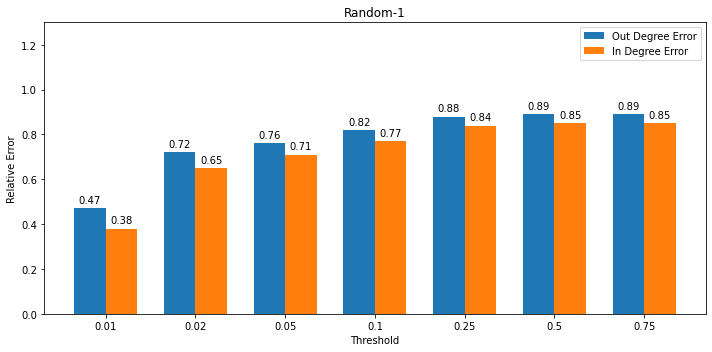

In [82]:
labels = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
rects1 = ax.bar(x - width/2, s_out_tot , width, label='Out Degree Error')
rects2 = ax.bar(x + width/2, s_in_tot, width, label='In Degree Error')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 1.3)
ax.set_xlabel('Threshold')
ax.set_ylabel('Relative Error')
ax.set_title("Random-1")
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Nx queries

In [11]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [53]:
t0 = time.time()
print(nx.diameter(s))
t1 = time.time()
print('running time', round(t1-t0,2))

3
running time 0.15


In [54]:
#average clustering
t0 = time.time()
nx.average_clustering(s)
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.06


In [22]:
# minimum cut
t0 = time.time()
print(nx.minimum_node_cut(G0))
t1 = time.time()
print('running time', round(t1-t0,2))

{299}
running time 95.29


## Queries

In [77]:
A = nx.adjacency_matrix(G)

In [24]:
#err(A,A_S_lifted)
print('Error l2: with A_S', round(linalg.norm(A.A-S.A)))

Error l2: with A_S 13114793


In [45]:
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)
len(s.edges())

4633

In [46]:
mean(S.A)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  """Entry point for launching an IPython kernel.


1696.795674491348

In [272]:
#sparsity of S (kxk)
print('Number of zeros in the lifted summary matrix',np.count_nonzero(S.A==0))

Number of zeros in the lifted summary matrix 7686


In [78]:
#adjacency queries
# discretize 
A = A.A
S_probs_G = S_probs_G.A
A[A>0] = 1

In [79]:
probs_G = S_probs_G
probs_G[S_probs_G<0.25] = 0
probs_G[S_probs_G>=0.25] = 1

In [80]:
s=0
for i in range(1000):
    s += hamming(A[i,:], probs_G[i,:]) * len(A)  # hamming distance
print("Hamming distance in adjacency queries", s/1000)

Hamming distance in adjacency queries 9.051


In [232]:
# top degree queries
def precision(k, deg, degS):
    l1 = sorted(deg, key=deg.get, reverse=True)[:k]
    l2 = sorted(degS, key=degS.get, reverse=True)[:k]
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [237]:
# top degree queries
# degree queries
A = nx.adjacency_matrix(G)
deg = dict()
for idx,row in enumerate(A):
    deg[idx] = np.sum(row)

    
degS = dict()
for idx,row in enumerate(S_G):
    degS[idx] = np.sum(row)
    
print(precision(10, deg, degS))
print(precision(50, deg, degS))
print(precision(100, deg, degS))

0.7
0.5
0.49


## Triangles

In [83]:
G2 = G.to_undirected()

In [84]:
sum(list(nx.triangles(G2).values())) / 3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  """Entry point for launching an IPython kernel.


1253.0

In [59]:
#Riondato
t0 = time.time()
t = 0
for i in tqdm(range(k)):
    n_i = len(partition[i])
    pi_ii = S_probs[i,i] * n_i / (n_i - 1) if n_i > 1 else 0
    t += scipy.special.binom(n_i,3) * pi_ii**3
    for j in range(i+1, k):
        pi_ij = (S_probs[i,j] + S_probs[j,i]) - (S_probs[i,j] * S_probs[j,i])
        n_j = len(partition[j])
        pi_jj = S_probs[j,j] * n_j / (n_j-1) if n_j > 1 else 0
        t += pi_ij**2*(scipy.special.binom(n_i,2)*n_j*pi_ii + scipy.special.binom(n_j,2)*n_i*pi_jj)
        for w in range(j+1,k):
            n_w = len(partition[w])
            pi_jw = (S_probs[j,w] + S_probs[j,w]) - (S_probs[j,w] * S_probs[j,w])
            pi_wi = (S_probs[w,i] + S_probs[i,w]) - (S_probs[w,i] * S_probs[i,w])
            t += n_i*n_j*n_w*pi_ij*pi_jw*pi_wi
print("Expected Number of triangles: ", round(t))
t1 = time.time()
print('running time', round(t1-t0,2))

100%|██████████| 350/350 [02:27<00:00,  2.38it/s]

Expected Number of triangles:  929
running time 147.1


## Centrality measures

In [23]:
def precision(k, l1, l2):
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [35]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [36]:
prG = nx.pagerank(G)
prS = nx.pagerank(s)

In [41]:
prG = nx.closeness_centrality(G)
prS = nx.closeness_centrality(s)

In [37]:
#normalization for pagerank
for i in range(k):
    prS[i] = prS[i]/len(partition[i])

In [56]:
#normalization for the degree centrality
for i in range(k):
    if S[i,i] !=0:
        prS[i] = prS[i] + (len(partition[i]) - 1)

In [38]:
#assign the centrality of the supernode to the nodes inside it
prSG = {}
for k,v in prS.items():
    for el in partition[k]:
        prSG[el] = v

In [49]:
th = sorted(list(prSG.values()), reverse=True)[99]

In [50]:
for idx,el in enumerate(sorted(list(prSG.values()), reverse=True)):
    if el<th:
        print(idx)
        k2 = idx
        break

100


In [51]:
k1 = 100
l1 = sorted(prG, key=prG.get, reverse=True)[:k1]
l2 = sorted(prSG, key=prSG.get, reverse=True)[:k2]

# measures
r = precision(k1,l1,l2)
p = precision(k2,l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.2
Recall: 0.2
f1 measure 0.20000000000000004


## Core decomposition

In [26]:
t0 = time.time()
coreG = nx.core_number(G)
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.01


In [49]:
t0 = time.time()
s.remove_edges_from(nx.selfloop_edges(s))
coreS = nx.core_number(s)
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.01


In [161]:
coreS_dict = {}
for k, v in coreS.items():
    for node in partition[k]:
        coreS_dict[node] = v 

In [162]:
#inner most core

l1 = [k for k in coreG.keys() if coreG[k]==max(coreG.values())]
l2 = [k for k in coreS.keys() if coreS[k]==max(coreS.values())]

print('Nodes with the largest core number in the input:', len(l1))
print('Nodes with the largest core number in the input:', len(l2))

# measures
r = precision(len(l1),l1,l2)
p = precision(len(l2),l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Nodes with the largest core number in the input: 869
Nodes with the largest core number in the input: 188
Precision: 0.898936170212766
Recall: 0.19447640966628307
f1 measure 0.31977294228949854


## Shortest Path

In [28]:
# sample 100 couples of nodes 
sample1 = random.sample(G.nodes, 1000)
sample2 = random.sample(G.nodes, 1000)
sample = [list(x) for x in zip(sample1, sample2)]

In [194]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(s, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [238]:
def shortest_path(G, s, couple, w):
    avg_err_same_supernode = []
    percentage_err_same_supernode = []

    avg_err = []
    percentage_err = []

    for couple in sample:
        spG = nx.shortest_path_length(G, source=couple[0], target=couple[1], weight= w, method='dijkstra')
        s_i = supernode[couple[0]]
        s_j = supernode[couple[1]]
        if s_i == s_j:
            if S[s_i, s_i] != 0:
                spS = S[s_i, s_i]
                #print('spS e spG', spS,spG)
            else:
                spS = shortest_distance(s, s_i, w)

            avg_err_same_supernode.append(abs(spG-spS))
            percentage_err_same_supernode.append(abs(spG-spS)/spG)

        else:
            spS = nx.shortest_path_length(s, source=s_i, target=s_j, weight=w, method='dijkstra')
            avg_err.append(abs(spG-spS))
            percentage_err.append(abs(spG-spS)/spG if abs(spG-spS)/spG<1 else 1) 
        
        #print(abs(spG-spS))
    print('Average Error', (np.mean(avg_err_same_supernode)+np.mean(avg_err))/2)
    print('Percentage Error', (np.mean(percentage_err_same_supernode)+ np.mean(percentage_err))/2)

In [226]:
#unweighted version
shortest_path(G,s,couple,None)

Average Error 2.6796104905904055
Percentage Error 0.8174601704273081


In [239]:
#weighted version
shortest_path(G,s,couple,'weight')

Average Error 187111.51900080687
Percentage Error 0.9927663286560815


## Cluster of nx graph

In [24]:
# cluster : size
cluster={}
for k,v in partition.items():
    cluster[k] = len(v)
s = np.array([key for key, val in cluster.items() for _ in range(val)])

In [25]:
n=1000

In [26]:
print('median', np.median(list(cluster.values())))
print('mean', np.mean(list(cluster.values())))
print('variance', np.var(list(cluster.values())))
print('max', np.max(list(cluster.values())))
print('max percentage', np.max(list(cluster.values()))/n)

median 1.0
mean 2.857142857142857
variance 962.071020408163
max 582
max percentage 0.582


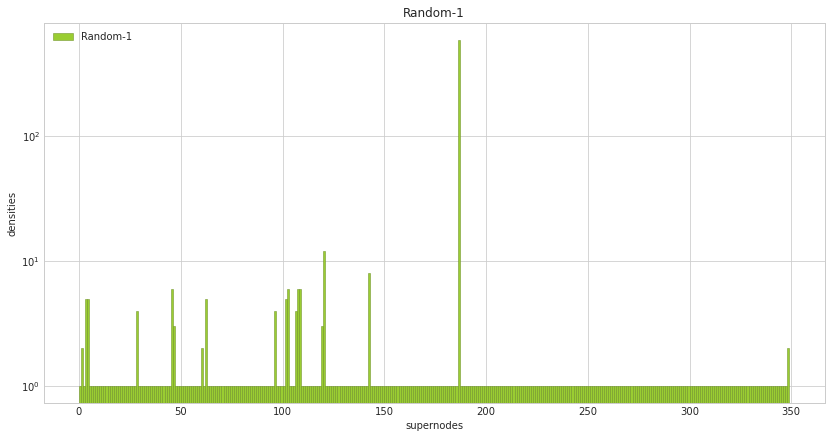

In [27]:
#cluster distribution

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(s, bins=k, facecolor = 'yellowgreen', edgecolor='olivedrab',  linewidth=0.5, log=True, label = 'Random-1')
plt.title('Random-1') 
plt.xlabel('supernodes') 
plt.ylabel('densities') 
plt.legend(loc="upper left")
plt.show()

## Clusters comparison

In [19]:
cluster2 = np.load('my_file.npy',allow_pickle='TRUE').item()

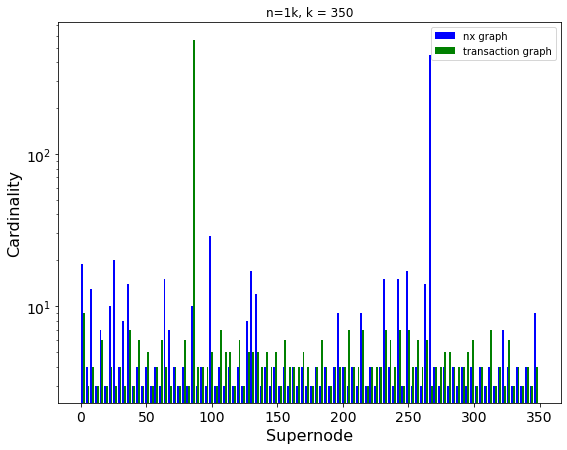

In [144]:
colors = ['b','g']
nxg = np.array([key for key, val in cluster.items() for _ in range(val)])
gen =  np.array([key for key, val in cluster2.items() for _ in range(val)])
#plots the histogram
fig, ax1 = plt.subplots(figsize=(9,7))
ax1.hist([nxg,gen],color=colors, bins=100, log=True, label = ['nx graph','transaction graph'])
plt.title("n=1k, k = 350")
plt.xlabel("Supernode", fontsize=16)  
plt.ylabel("Cardinality", fontsize=16)
plt.legend(loc="upper right")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

In [62]:
print('Median', np.median(list(cluster.values())))
print('Mean', np.mean(list(cluster.values())))
print('Var', np.var(list(cluster.values())))

Median 1.0
Mean 4.0
Var 1548.648


In [21]:
print('Median', np.median(list(cluster2.values())))
print('Mean', np.mean(list(cluster2.values())))
print('Var', np.var(list(cluster2.values())))

Median 1.0
Mean 2.857142857142857
Var 896.1110204081634


In [3]:
from random import random
random()

0.8951345985268303

## Community Detection

In [25]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [26]:
t0 = time.time()
community = greedy_modularity_communities(s, weight='weight')
t1 = time.time()
print('Running time:', round(t1-t0,2)) 

Running time: 0.25


In [27]:
# Assing to each node the community of the supernode it belongs to

communityS = []
for idx in range(len(community)):
    comm_idx = []
    for el in community[idx]:
        for node in partition[el]:
            comm_idx.append(node)
    communityS.append(comm_idx)

In [28]:
#modularity score
print(round(nx_comm.modularity(G, communityS),2))

0.07


# Connected Components

## Connected Components

In [17]:
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [18]:
#Number
len([c for c in nx.weakly_connected_components(s)])

1

In [11]:
# largest cc size
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

NetworkXNotImplemented: not implemented for directed type

In [39]:
# largest cc diamter and min cut size
subs = s.subgraph(largest_cc)
print('largest cc diameter', nx.diameter(subs))
print('largest cc min cut size', len(nx.minimum_node_cut(subs)))

largest cc diameter 4


KeyboardInterrupt: 

# Possible Worlds


In [16]:
# for weighted graphs
def world(graph_type, matrix, prob_matrix):
    s = nx.from_numpy_matrix(np.matrix(matrix.A), create_using=graph_type)
    s_prob = nx.from_numpy_matrix(np.matrix(prob_matrix.A), create_using=graph_type)
    world = s.copy()
    for edge in s_prob.edges(data=True):
        sample = random.uniform(0,1)
        if edge[-1]['weight'] < sample:
            world.remove_edge(edge[0], edge[1])
    return world

In [17]:
possible_worlds = []
for i in range(100):
    possible_worlds.append(world(nx.DiGraph, S, S_probs))

## Single Value Queries

In [16]:
# mean value of edges in the possible worlds set
mean = 0

for graph in possible_worlds:
    mean += len(graph.edges())
    
print('mean number of edges', round(mean/100)) 

mean number of edges 780


In [56]:
# diameter for directed graphs

diameter_largest_cc = 0
diameter = 0
t1 = time.time()
for graph in tqdm(possible_worlds):
    #largest_cc = max(nx.strongly_connected_components(graph), key=len)
    #sub_graph = graph.subgraph(largest_cc)
    #diameter_largest_cc += nx.diameter(sub_graph)
    if nx.is_strongly_connected(graph) == True:
        diameter += nx.diameter(graph)
t2 = time.time()

print('Running Time:', round(t2-t1,2))
print('diameter largest cc:', round(diameter_largest_cc/100))
print('diameter:', round(diameter/100))

100%|██████████| 100/100 [00:00<00:00, 634.98it/s]

Running Time: 0.16
diameter largest cc: 0
diameter: 0


In [57]:
# average cluster coefficient
t1 = time.time()
avg_clustering = 0
for graph in tqdm(possible_worlds):
    avg_clustering += nx.average_clustering(graph)

t2 = time.time()

print('Running Time:', round(t2-t1,2))
print('average clustering coefficient:', round(avg_clustering/100, 3))

100%|██████████| 100/100 [00:00<00:00, 200.18it/s]

Running Time: 0.5
average clustering coefficient: 0.009


In [22]:
# connected component

diameter = 0
min_cut = 0
number_cc = 0
size = 0
for graph in tqdm(possible_worlds):
    largest_cc = max(nx.strongly_connected_components(graph), key=len)
    size += len(largest_cc)
    number_cc += len([c for c in nx.weakly_connected_components(graph)])
    sub_graph = graph.subgraph(largest_cc)
    min_cut += len(nx.minimum_node_cut(sub_graph))
    diameter += nx.diameter(sub_graph)

print('Number of cc:', round(number_cc/100))   
print('Size largest cc:', round(size/100))
print('Min cut size largest cc:', round(min_cut/100))
print('Diameter largest cc:', round(diameter/100))

100%|██████████| 100/100 [03:34<00:00,  2.15s/it]

Number of cc: 1
Size largest cc: 219
Min cut size largest cc: 1
Diameter largest cc: 11


In [26]:
number_cc/100

1.06

### Shortest Path

In [51]:
# sample one couples of nodes 
#largest_cc = sorted(nx.weakly_connected_components(G), reverse=1)[0]
sample1 = random.sample(G.nodes(),1)[0]
sample2 = random.sample(G.nodes(), 1)[0]
sample = [sample1, sample2]

In [52]:
sample

[541, 342]

In [53]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(s, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [54]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(start): 
        currentDistance = nx.shortest_path_length(G, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [55]:
def shortest_path(s, couple,w):  
    
    #shortest path for the summary
    s_i = supernode[couple[0]]
    s_j = supernode[couple[1]]
    if s_i == s_j:
        if S[s_i, s_j] != 0:
            spS = 1
        else:
            spS = shortest_distance(s, s_i, w)

    else:
         spS = nx.shortest_path_length(s, source=s_i, target=s_j, method='dijkstra', weight=w)
       
    return spS

In [56]:
#shortest path for the input
spG = nx.shortest_path_length(G, source=sample[0], target=sample[1], method='dijkstra', weight=None)

spS = []
for graph in tqdm(possible_worlds):
    spS.append(shortest_path(graph,sample,None))
    

100%|██████████| 100/100 [00:00<00:00, 55392.29it/s]


In [57]:
sp_dict = {}
for k,v in Counter(spS).items():
    sp_dict[k] = v/100

In [58]:
sp_dict

{1: 1.0}

In [59]:
spG

4

In [60]:
spS = 1
print('Average Error:',abs(spG-spS))
print('Percentage Err:',abs(spG-spS)/spG)

Average Error: 3
Percentage Err: 0.75


## Set Queries

In [12]:
def precision(k, l1, l2):
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return round(intersect/k,2)

In [13]:
def centrality_query(centrality_type, possible_world, k, partition):
    sets = []
    for graph in tqdm(possible_worlds):
        centrality = centrality_type(graph)
        
        if centrality_type == nx.pagerank:
            for i in range(k): #normalization for pagerank
                     centrality[i] = centrality[i]/len(partition[i])
       
        if centrality_type == nx.degree_centrality:
            for i in range(k):       #normalization for the degree centrality
                if graph.has_edge(i,i) == True:
                    centrality[i] = centrality[i] + (len(partition[i]) - 1)

        #top = sorted(centrality, key=centrality.get, reverse=True)[:100]
        
        projection = {}
        for k,v in centrality.items():
            for el in partition[k]:
                projection[el] = v

        th = sorted(list(projection.values()), reverse=True)[99]
        k2 = len(graph.nodes())
        for idx,el in enumerate(sorted(list(projection.values()), reverse=True)):
            if el<th:
                k2 = idx
                break
        answer = sorted(projection, key=projection.get, reverse=True)[:k2]
        sets.append(answer)
    return sets

In [17]:
centrality_type = nx.closeness_centrality
t1 = time.time()
answers = centrality_query(centrality_type, possible_worlds, k, partition)
t2 = time.time()

print('Running Time:', round(t2-t1,2))

100%|██████████| 100/100 [00:07<00:00, 13.06it/s]

Running Time: 7.66


In [44]:
#centrality query using intersection

k1 = 100
final_answer = set.intersection(*map(set,answers))
centralityG = centrality_type(G)
topG = sorted(centralityG, key=centralityG.get, reverse=True)[:k1]



# measures
r = precision(k1,topG, final_answer)
p = precision(len(final_answer), topG, final_answer)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.5
Recall: 0.01
f1 measure 0.0196078431372549


In [43]:
#centrality query using frequency score

#k1 = 100
#centralityG = centrality_type(G)
#topG = sorted(centralityG, key=centralityG.get, reverse=True)[:k1]

flat_answers = [item for sublist in answers for item in sublist]
occurrences = Counter(flat_answers)
th = sorted(occurrences.values(), reverse=True)[k1]
final_answer = [k for k,v in occurrences.items() if v>=th]

# measures
r = precision(k1, topG, final_answer)
p = precision(len(final_answer), topG, final_answer)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.17
Recall: 0.18
f1 measure 0.17485714285714288


In [18]:
#inner most core
def inner_most_core(possible_world, k, partition):

    sets = []
    for graph in tqdm(possible_world):
        graph.remove_edges_from(nx.selfloop_edges(graph))
        coreS = nx.core_number(graph)
        
        coreS_dict = {}
        for k, v in coreS.items():
            for node in partition[k]:
                coreS_dict[node] = v 
    
        topSinG = [k for k in coreS_dict.keys() if coreS_dict[k]==max(coreS_dict.values())]

        sets.append(topSinG)
    return sets

In [19]:
t1 = time.time()
answers = inner_most_core(possible_worlds, k, partition)
t2 = time.time()

print('Running Time:', round(t2-t1,2))

100%|██████████| 100/100 [00:02<00:00, 44.99it/s]

Running Time: 2.23


In [75]:
#inner most core queries using intersection


final_answer = set.intersection(*map(set,answers))
coreG = nx.core_number(G)
topG = [k for k in coreG.keys() if coreG[k]==max(coreG.values())]

# measures
r = precision(len(topG),topG,final_answer)
p = precision(len(final_answer),topG, final_answer)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.99
Recall: 0.19
f1 measure 0.3188135593220339


In [77]:
#inner most core queries using frequency score

flat_answers = [item for sublist in answers for item in sublist]
occurences = Counter(flat_answers)
th = sorted(occurrences.values(), reverse=True)[k1]
final_answer = [k for k,v in occurrences.items() if v>=th]



# measures
r = precision(len(topG),topG,final_answer)
p = precision(len(final_answer),topG, final_answer)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', round(2*p*r/(p+r),2))

Precision: 0.91
Recall: 0.11
f1 measure 0.2
